## Dataset: Ucdavis

| Augmentations | Filters | Training | Validation | Classification | Testing |
|---------------|---------|----------|------------|----------------|---------|
| Change in Inter-Arrival Time (IAT) | none | pretraining | val | train | script |

In [1]:
# -- IMPORTS --

import os
os.chdir('/workplace/flowmind/')

import csv
import sys

# torch imports
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy
from torchdata.datapipes.iter import FileLister

# flowmind imports
from flowmind.contrastive import NTXentLoss

# livelossplot imports
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# others
from functools import partial

# common imports
os.chdir('/workplace/xcocek00/common/')
from augmentations import augment_iat
os.chdir('/workplace/xcocek00/common/')
from dataloader import create_flowpic_dataloader
os.chdir('/workplace/xcocek00/common/')
from nn import CNN, MLP

# sets csv limit
csv.field_size_limit(sys.maxsize)

# sets the device to use gpu if available, if not, use cpu
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


/root/miniconda3/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
# -- custom remap

def remap_label(t: tuple[torch.Tensor, torch.Tensor, str], labels_d: dict[str, int]) -> tuple[torch.Tensor, torch.Tensor, int]:
    return t[0], t[1], labels_d[t[2]]

labels_ucdavis = [
    "google-doc",
    "google-drive",
    "google-music",
    "google-search",
    "youtube",
]

labels_ucdavis_d = {label: i for i, label in enumerate(labels_ucdavis)}

remap_label_ucdavis = partial(remap_label, labels_d=labels_ucdavis_d)


In [3]:
# -- DATA LOADERS for ucdavis --
# dataloaders yield tuple (flowpic1, flowpic2, label)
# using only 15 seconds of the flow

# 0 - debug prints are turned off
# 1 - debug prints are turned on
DEBUG = 0

# dataloader used for training
dl_train = create_flowpic_dataloader(
    dir_path="/workplace/datasets/ucdavis/final-splits/pretraining.csv",    
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    flow_transform_1=augment_iat,
    flow_transform_2=augment_iat,
    bidirectional = False,
    dp_transform=lambda dp: dp.map(remap_label_ucdavis),
)

# dataloader used for validation
dl_val = create_flowpic_dataloader(
    dir_path="/workplace/datasets/ucdavis/final-splits/val.csv",   
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    flow_transform_1=augment_iat,
    flow_transform_2=augment_iat,
    bidirectional = False,    
    dp_transform=lambda dp: dp.map(remap_label_ucdavis),
)

# dataloader used for classification head
dl_class = create_flowpic_dataloader(
    dir_path="/workplace/datasets/ucdavis/final-splits/train.csv",
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    bidirectional = False,   
    dp_transform=lambda dp: dp.map(remap_label_ucdavis),
)

# dataloader used for unseen data to test model
dl_test = create_flowpic_dataloader(
    dir_path="/workplace/datasets/ucdavis/final-splits/script.csv",  
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    bidirectional = False,   
    dp_transform=lambda dp: dp.map(remap_label_ucdavis),
)

if DEBUG:    
    print(type(dl_train))
    dim_val(dl_train)
    print_batch(dl_train, "training")
    print_batch(dl_class, "classification")
    debug_batch(dl_train)

/root/miniconda3/lib/python3.12/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [4]:
# -- training loops--

def train(model, dataloader, optimizer, contrastive_loss_fn, log):
    '''
    Training loop

    Args:
        model: CNN model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        optimizer: chosen optimizer
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''

    model.train()
    total_loss = 0.0
    batches = 0

    # label not needed in -> _
    for flowpic1, flowpic2, _ in dataloader:
        flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

        optimizer.zero_grad()

        z1 = model(flowpic1)
        z2 = model(flowpic2)
        
        # contrastive loss
        loss = contrastive_loss_fn(z1, z2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1
        
    total_loss /= batches
    log["loss"] = total_loss

    return total_loss

def val(model, dataloader, contrastive_loss_fn, log):
    '''
    Validation loop

    Args:
        model: CNN model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''
    with torch.no_grad():
        model.eval()
        total_loss = 0.0
        batches = 0

        # label not needed in -> _
        for flowpic1, flowpic2, _ in dataloader:
            flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

            z1 = model(flowpic1)
            z2 = model(flowpic2)
            
            # contrastive loss
            loss = contrastive_loss_fn(z1, z2)

            total_loss += loss.item()
            batches += 1

        total_loss /= batches
        log["val_loss"] = total_loss

    return total_loss

def classification(CNN_model, MLP_model, dataloader, log, loss_fn, accuracy, optimizer):
    '''
    Classification loop

    Args:
        CNN_model: CNN model 
        MLP_model: MLP model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        log: for log collection
        loss_fn: chosen loss function
        accuracy: chosen model accuracy
        optimizer: chosen optimizer

    Returns:
        classification loss 
    '''

    # freeze the encoder
    for param in CNN_model.encoder.parameters():
        param.requires_grad = False

    # remove projection head
    CNN_model.projection = nn.Sequential()
    
    # set models
    CNN_model.eval()
    MLP_model.train()

    classification_loss = 0.0
    batches = 0

    for flowpic, _, label in dataloader:
        optimizer.zero_grad()

        flowpic, label = flowpic.to(device), label.to(device)

        with torch.no_grad():
            embeddings = CNN_model.encoder(flowpic)
        
        y_pred = MLP_model(embeddings)

        loss = loss_fn(y_pred, label)
        loss.backward()
        optimizer.step()

        classification_loss += loss.item()
        batches += 1
        
        accuracy.update(y_pred, label)
    
    classification_loss /= batches

    log["classification_loss"] = classification_loss
    log["accuracy"] = accuracy.compute()
        
    accuracy.reset()

    return classification_loss

def testing(CNN_model, MLP_model, dataloader, log, loss_fn, accuracy):
    '''
    Testing loop

    Args:
        CNN_model: CNN model 
        MLP_model: MLP model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        log: for log collection
        loss_fn: chosen loss function
        accuracy: chosen model accuracy
        optimizer: chosen optimizer

    Returns:
        training loss 
    '''

    # freeze the encoder
    for param in CNN_model.encoder.parameters():
        param.requires_grad = False
    
    # set models
    CNN_model.eval()
    MLP_model.eval()

    test_loss = 0.0
    batches = 0

    with torch.no_grad():
        for flowpic_t, _, label in dataloader:
            flowpic_t, label = flowpic_t.to(device), label.to(device)

            embeddings = CNN_model.encoder(flowpic_t)
            y_pred = MLP_model(embeddings)

            loss = loss_fn(y_pred, label)
            test_loss += loss.item()
            batches += 1

            accuracy.update(y_pred, label)
    
        test_loss /= batches
    
        log["model_loss"] = test_loss
        log["model_accuracy"] = accuracy.compute()
            
        accuracy.reset()

    return test_loss



In [5]:
# -- ucdavis dataset --

classes = 5

# CNN definition
cnn_model = CNN()
cnn_model = cnn_model.to(device)

# optimizer
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# NT-Xent loss function
contrastive_loss_fn = NTXentLoss(temperature=0.07)

cnn_liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

# Linear classifier definition
mlp_model = MLP(classes)
mlp_model = mlp_model.to(device)

# optimizer
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# loss function
mlp_loss_fn = nn.CrossEntropyLoss()

mlp_accuracy = MulticlassAccuracy()

mlp_liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

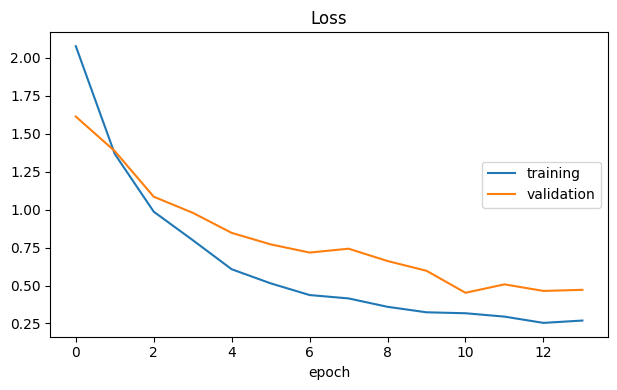

Stopping ... epoch  13


In [6]:
# -- traning CNN --

# set params for early stopping
patience = 3
best_loss = float('inf')
no_improvement = 0

for epoch in range(30):
    log = {}
    train_loss = train(cnn_model, dl_train, cnn_optimizer, contrastive_loss_fn, log)
    val_loss = val(cnn_model, dl_val, contrastive_loss_fn, log)

    cnn_liveloss.update(log)
    cnn_liveloss.send()

    if val_loss < best_loss:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Stopping ... epoch ", epoch)
        break 

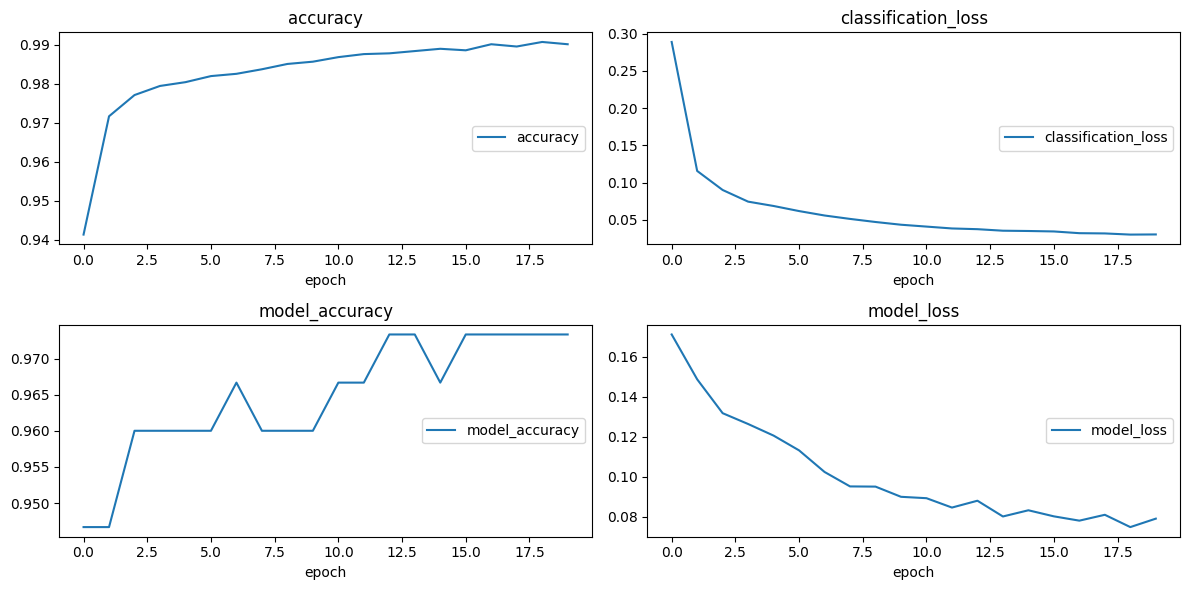

Final accuracy:  tensor(0.9733)
Best accuracy:  tensor(0.9733)


In [7]:
# -- training linear classifier --

# set params for early stopping
best_loss = float('inf')
no_improvement = 0
min_improvement = 0.001
patience = 5 
best_acc = float('-inf')

for epoch in range(20):
    log = {}
    classification_loss = classification(cnn_model, mlp_model, dl_class, log, mlp_loss_fn, mlp_accuracy, mlp_optimizer)   
    test = testing(cnn_model, mlp_model, dl_test, log, mlp_loss_fn, mlp_accuracy)   

    mlp_liveloss.update(log)
    mlp_liveloss.send()

    if best_acc < log['model_accuracy']:
        best_acc = log['model_accuracy']

    # early stopping
    if best_loss - classification_loss > min_improvement:
        best_loss = classification_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Early stopping - epoch ", epoch)
        break

f_acc = log['model_accuracy']
print("Final accuracy: ", f_acc)
print("Best accuracy: ", best_acc)
    